In [1]:
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay
import pandas as pd
import numpy as np

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import statsmodels.api as sm

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import StandardScaler

from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.inspection import PartialDependenceDisplay

# Read the cleaned CSV file
fraud_data = pd.read_csv('clean_fraud_data.csv')

# Display the first few rows
fraud_data.head()

/tmp/ipykernel_144546/697959500.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,fraud_bool,income,name_email_similarity,salary,prev_address_months_count,current_address_months_count,customer_age,date_of_birth,days_since_request,intended_balcon_amount,...,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,email_domain,velocity24h_OutOfRange,velocity4w_OutOfRange,creditLimit_OutOfRange
0,0.0,0.3,0.986506,42084.0,NaN,25.0,43.0,1982-09-26,0.006735,102.453711,...,NaN,linux,1.0,1.0,0.0,0,gmail.com,0,0,0
1,0.0,0.8,0.617426,105266.0,NaN,89.0,21.0,2004-10-18,0.010095,NaN,...,3.363854,other,1.0,1.0,0.0,0,yahoo.com,0,0,0
2,0.0,0.8,0.996707,122830.0,9.0,14.0,43.0,1982-01-01,0.012316,NaN,...,22.730559,windows,0.0,1.0,0.0,0,aol.com,0,0,0
3,0.0,0.6,0.475100,83960.0,11.0,14.0,35.0,1990-09-05,0.006991,NaN,...,15.215816,linux,1.0,1.0,0.0,0,aol.com,0,0,0
4,0.0,0.9,0.842307,146723.0,NaN,29.0,45.0,1980-02-11,5.742626,47.152498,...,3.743048,other,0.0,1.0,0.0,0,agency.io,0,0,0


In [2]:
# Removal of some redundant columns
fraud_data = fraud_data.drop(['name_email_similarity','date_of_birth',
                              'creditLimit_OutOfRange','velocity24h_OutOfRange',
                              'velocity4w_OutOfRange','zip_count_4w'], axis=1)


In [3]:
train = fraud_data.groupby("fraud_bool").sample(n = 5000, random_state = 1234)

test = fraud_data.loc[fraud_data.index.difference(train.index)]

In [4]:
# filling in number dtypes with median and flagging with missing 
train_o = train.copy()
num_cols = train_o.select_dtypes(include='number').columns

for col in num_cols:
    if train_o[col].isnull().any():
        # Create missing flag column
        train_o[f'{col}_was_missing'] = train_o[col].isnull().astype(int)

        # Impute with median
        median = train_o[col].median()
        train_o[col] = train_o[col].fillna(median)
print(train_o.columns)

Index(['fraud_bool', 'income', 'salary', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'email_domain', 'income_was_missing', 'salary_was_missing',
       'prev_address_months_count_was_missing',
       'current_address_months_count_was_missing', 'customer_age_was_missing',
       'days_since_request_was_missing', 'intended_balcon_amount_was_missing',
       'velocity_6h_was_missing', 'velo

In [5]:
predictors = train_o.drop(columns=['fraud_bool'])
predictors = pd.get_dummies(predictors, drop_first=True)
predictors = predictors.astype(float)

X = predictors
y = train_o['fraud_bool']

In [6]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Separate categorical (dummy) vs. continuous features
categorical_features = [col for col in X.columns if X[col].nunique() == 2]
continuous_features = [col for col in X.columns if X[col].nunique() > 2]

X_cat = X[categorical_features]
X_cont = X[continuous_features]

# Fit SelectKBest for Categorical Variables
selector = SelectKBest(score_func=chi2, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cat, y)

# Create a DataFrame with feature names, Chi2-scores, and p-values
scores_cat_df = pd.DataFrame({
    'Feature': X_cat.columns,
    'Chi2_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cat_features = scores_cat_df[scores_cat_df['p_value'] < 0.002]['Feature']

# Fit SelectKBest for Continous Variables
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cont, y)

# Create a DataFrame with feature names, F-scores, and p-values
scores_cont_df = pd.DataFrame({
    'Feature': X_cont.columns,
    'F_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cont_features = scores_cont_df[scores_cont_df['p_value'] < 0.002]['Feature']

# Create a new DataFrame with only those selected columns
X_reduced = X[selected_cat_features.tolist() + selected_cont_features.tolist()]

X_reduced.head()

,email_is_free,phone_home_valid,has_other_cards,foreign_request,keep_alive_session,prev_address_months_count_was_missing,intended_balcon_amount_was_missing,bank_months_count_was_missing,payment_type_AC,employment_status_CB,...,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w
290549,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,4950.866293,5103.168101,3988.223415,0.0,5.0,185.0,1.0,500.0,4.510737,1.0
686524,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,5588.771169,5003.015930,4365.296689,6.0,11.0,81.0,25.0,200.0,2.660806,1.0
288725,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,8881.558283,4769.340169,5589.870662,931.0,14.0,150.0,15.0,200.0,6.802462,1.0
960129,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,896.764172,2519.626534,3144.682958,0.0,6.0,134.0,15.0,200.0,16.149678,1.0
792013,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2807.286772,3123.897618,4316.126791,1342.0,3.0,102.0,15.0,200.0,2.127879,0.0


In [7]:
def check_quasi_complete_separation(X, y):
    """
    Checks each categorical predictor in X for quasi-complete separation with respect to binary target y.

    Parameters:
    - X: pd.DataFrame of predictors (categorical variables)
    - y: pd.Series of binary target variable (e.g., 0/1 or True/False)

    Returns:
    - List of variable names that exhibit quasi-complete separation
    """
    problematic_vars = []

    for col in X.columns:
        ct = pd.crosstab(X[col], y)

        # Check if any category (row) has a zero in any outcome class
        if (ct == 0).any(axis=1).any():
            print(f"⚠️ Quasi-complete separation detected in '{col}'")
            print(ct)
            print()
            problematic_vars.append(col)

    return problematic_vars

In [8]:
# Create a new DataFrame with only those selected columns
X_cat_reduced = X_reduced[selected_cat_features.tolist()]

problem_vars = check_quasi_complete_separation(X_cat_reduced, y)

In [9]:
X_reduced = X_reduced.drop(problem_vars, axis = 1)

In [10]:
X_selected = X_reduced.copy()

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]

print(vif_data)

                                  feature         VIF
0                           email_is_free    8.630742
1                        phone_home_valid    1.636280
2                         has_other_cards    1.270166
3                         foreign_request    1.052731
4                      keep_alive_session    2.003975
5   prev_address_months_count_was_missing    7.498892
6      intended_balcon_amount_was_missing    6.238499
7           bank_months_count_was_missing    7.398166
8                         payment_type_AC    7.448717
9                    employment_status_CB    1.194531
10                   employment_status_CC    1.238217
11                   employment_status_CD    1.053872
12                   employment_status_CE    1.034308
13                   employment_status_CF    1.089157
14                      housing_status_BB    1.787468
15                      housing_status_BC    2.164066
16                      housing_status_BE    1.545431
17                        de

In [11]:
vif_threshold = 10
features_to_keep = vif_data.loc[vif_data["VIF"] <= vif_threshold, "feature"]

X_selected = X_selected[features_to_keep].copy()

print("\nFeatures kept (VIF ≤ 10):")
print(features_to_keep.tolist())

print("\X_selected:", X_selected.shape)


Features kept (VIF ≤ 10):
['email_is_free', 'phone_home_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session', 'prev_address_months_count_was_missing', 'intended_balcon_amount_was_missing', 'bank_months_count_was_missing', 'payment_type_AC', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'housing_status_BB', 'housing_status_BC', 'housing_status_BE', 'device_os_linux', 'device_os_other', 'device_os_windows', 'month_3', 'month_6', 'month_7', 'email_domain_agency.io', 'email_domain_company.com', 'email_domain_finance.pro', 'email_domain_gmail.com', 'email_domain_gmx.com', 'email_domain_hotmail.com', 'email_domain_icloud.com', 'email_domain_lawfirm.legal', 'email_domain_protonmail.com', 'email_domain_startup.biz', 'email_domain_tech.info', 'email_domain_work.net', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'velocity_6h', 'bank_branch_count_8w', 'date_of_birth_distinct_em

## Random Forest

In [15]:
X_selectedrf = X_selected[features_to_keep].copy()

print("\nFeatures kept (VIF ≤ 10):")
print(features_to_keep.tolist())
print("\nX_selected shape:", X_selectedrf.shape)

rf_cls = RandomForestClassifier(
    n_estimators=800,
    random_state=1234,
    oob_score=True,             # out-of-bag score for generalization estimate
    class_weight='balanced'     # handles class imbalance
)


Features kept (VIF ≤ 10):
['email_is_free', 'phone_home_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session', 'prev_address_months_count_was_missing', 'intended_balcon_amount_was_missing', 'bank_months_count_was_missing', 'payment_type_AC', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'housing_status_BB', 'housing_status_BC', 'housing_status_BE', 'device_os_linux', 'device_os_other', 'device_os_windows', 'month_3', 'month_6', 'month_7', 'email_domain_agency.io', 'email_domain_company.com', 'email_domain_finance.pro', 'email_domain_gmail.com', 'email_domain_gmx.com', 'email_domain_hotmail.com', 'email_domain_icloud.com', 'email_domain_lawfirm.legal', 'email_domain_protonmail.com', 'email_domain_startup.biz', 'email_domain_tech.info', 'email_domain_work.net', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'velocity_6h', 'bank_branch_count_8w', 'date_of_birth_distinct_em

y shape: (10000,)
Unique values: [0. 1.]

OOB Accuracy: 0.7748

Top Feature Importances:
current_address_months_count             0.098211
credit_risk_score                        0.091541
customer_age                             0.073872
velocity_6h                              0.065214
session_length_in_minutes                0.063970
date_of_birth_distinct_emails_4w         0.057977
bank_branch_count_8w                     0.054933
device_os_windows                        0.054463
proposed_credit_limit                    0.039050
bank_months_count                        0.037341
keep_alive_session                       0.029010
phone_home_valid                         0.027338
has_other_cards                          0.024985
prev_address_months_count_was_missing    0.021595
housing_status_BE                        0.021404
dtype: float64


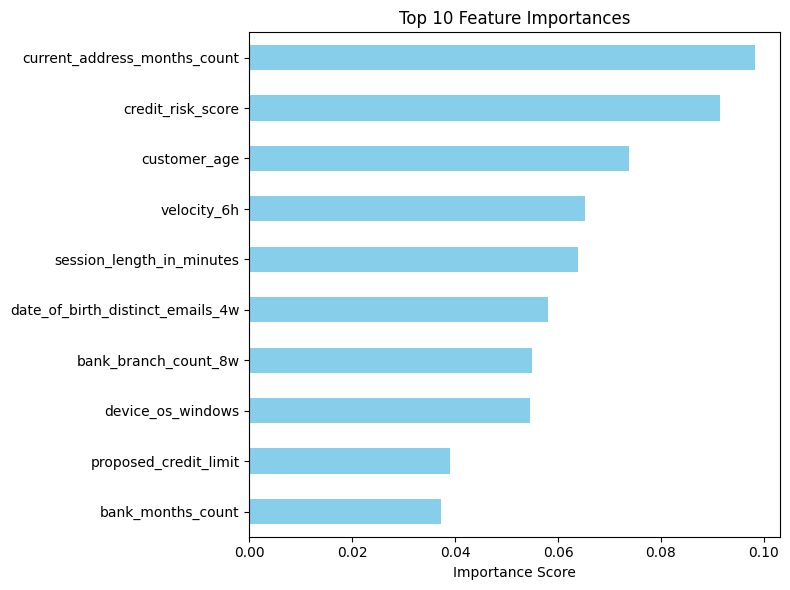

In [17]:
y = train_o['fraud_bool'].values.ravel()   # confirm your target column name
print("y shape:", y.shape)
print("Unique values:", np.unique(y))

rf_cls = RandomForestClassifier(
    n_estimators=100,
    random_state=1234,
    oob_score=True,
    class_weight='balanced'
)

rf_cls.fit(X_selectedrf, y)

print("\nOOB Accuracy:", rf_cls.oob_score_)

feature_importance = pd.Series(rf_cls.feature_importances_, index=X_selected.columns)
feature_importance = feature_importance.sort_values(ascending=False)

print("\nTop Feature Importances:")
print(feature_importance.head(15))

plt.figure(figsize=(8,6))
feature_importance.head(10).plot(kind='barh', color='skyblue', title="Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
rf_cls.oob_score_

In [18]:
%%time

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'max_features': [5, 6, 7, 8, 9],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800]
}

cv = KFold(n_splits=10, shuffle=True, random_state=1234)

rf_cls = RandomForestClassifier(random_state=1234, class_weight='balanced')

grid_search = GridSearchCV(
    estimator=rf_cls,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',  # or 'f1_weighted', 'roc_auc' depending on your goal
    n_jobs=-1            # use all cores for faster training
)

grid_search.fit(X_selectedrf, y)

print(grid_search.best_params_)

{'max_depth': 20, 'max_features': 6, 'n_estimators': 500}
CPU times: user 6.77 s, sys: 2.02 s, total: 8.78 s
Wall time: 1min 59s


In [21]:
%%time

# Step 1: Define the objective function
def objective(trial):
    # Define search space (equivalent to param_grid)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30])
    max_features = trial.suggest_int('max_features', 3, 7)
    n_estimators = trial.suggest_int('n_estimators', 100, 800, step=100)
    
    # Create Random Forest Classifier
    rf_cls = RandomForestClassifier(
        max_depth=max_depth,
        max_features=max_features,
        n_estimators=n_estimators,
        random_state=1234,
        class_weight='balanced'  # optional: handles class imbalance
    )
    
    # Stratified CV to preserve class proportions
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Evaluate using cross-validation (use 'accuracy', 'f1_weighted', or 'roc_auc')
    scores = cross_val_score(rf_cls, X_selectedrf, y, cv=cv, scoring='accuracy')
    
    return np.mean(scores)

# Step 2: Run the optimization
sampler = optuna.samplers.TPESampler(seed=1234)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Step 3: Best hyperparameters
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

[I 2025-11-13 21:00:28,781] A new study created in memory with name: no-name-5c21f870-58ff-4eb4-a804-1c5464f095e1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-13 21:00:55,027] Trial 0 finished with value: 0.7781 and parameters: {'max_depth': 30, 'max_features': 6, 'n_estimators': 300}. Best is trial 0 with value: 0.7781.
[I 2025-11-13 21:01:28,446] Trial 1 finished with value: 0.7819999999999999 and parameters: {'max_depth': 20, 'max_features': 4, 'n_estimators': 500}. Best is trial 1 with value: 0.7819999999999999.
[I 2025-11-13 21:01:33,701] Trial 2 finished with value: 0.7773000000000001 and parameters: {'max_depth': 10, 'max_features': 5, 'n_estimators': 100}. Best is trial 1 with value: 0.7819999999999999.
[I 2025-11-13 21:01:44,696] Trial 3 finished with value: 0.7812 and parameters: {'max_depth': 10, 'max_features': 3, 'n_estimators': 300}. Best is trial 1 with value: 0.7819999999999999.
[I 2025-11-13 21:02:19,299] Trial 4 finished with value: 0.7825 and parameters: {'max_depth': None, 'max_features': 4, 'n_estimators': 500}. Best is trial 4 with value: 0.7825.
[I 2025-11-13 21:03:11,788] Trial 5 finished with value: 0.7791

In [24]:
weight_1 = 1
weight_0 = (1000606 / 11146) / (5000 / 5000)

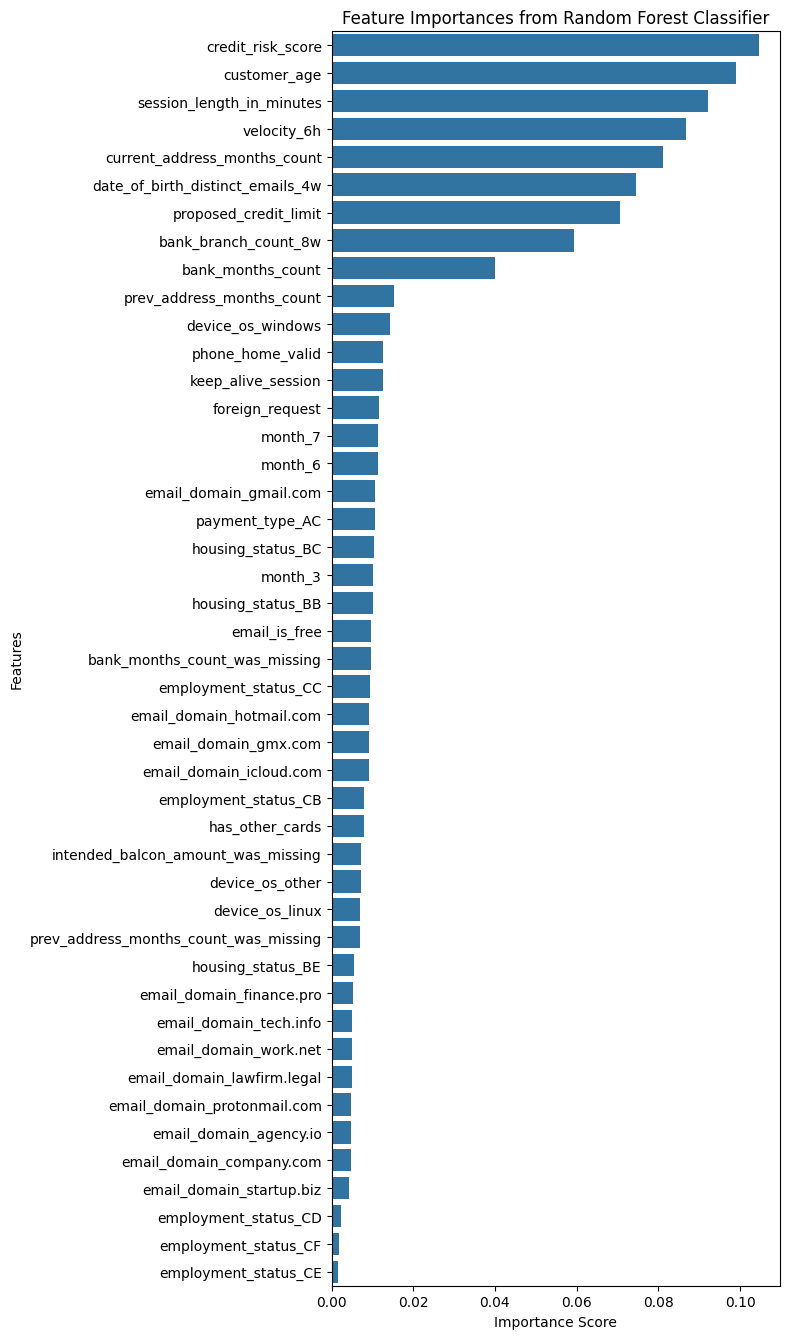

OOB Accuracy: 0.6364


In [25]:
# Random Forest Classifier
rf_cls = RandomForestClassifier(
    n_estimators=800,
    max_features=3,
    max_depth=20,
    random_state=1234,
    oob_score=True,
    class_weight={1: weight_1, 0: weight_0}  # optional for imbalanced classes
)

rf_cls.fit(X_selectedrf, y)

importances = rf_cls.feature_importances_

feature_importances = pd.Series(importances, index=X_selectedrf.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(8, len(sorted_importances) * 0.3))  # dynamic height
sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
plt.title("Feature Importances from Random Forest Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

print("OOB Accuracy:", rf_cls.oob_score_)

In [26]:
train_o['pred_prob'] = rf_cls.predict_proba(X_selectedrf)[:, 1]

threshold = 0.5
train_o['pred_class'] = (train_o['pred_prob'] >= threshold).astype(int)

print(train_o[['fraud_bool', 'pred_prob', 'pred_class']].head())

        fraud_bool  pred_prob  pred_class
290549         0.0   0.106260           0
686524         0.0   0.036370           0
288725         0.0   0.069928           0
960129         0.0   0.128568           0
792013         0.0   0.054345           0


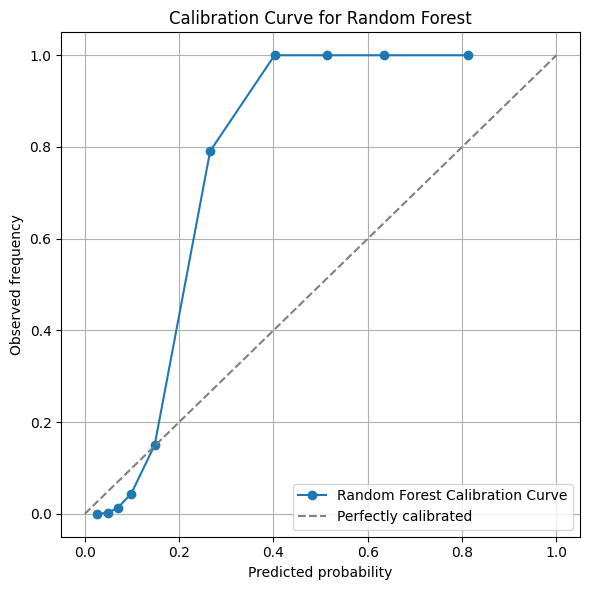

In [27]:
y_prob_rf = rf_cls.predict_proba(X_selectedrf)[:, 1]

prob_true, prob_pred = calibration_curve(
    train_o['fraud_bool'],  # true outcomes
    y_prob_rf,              # predicted probabilities from Random Forest
    n_bins=10,
    strategy='quantile'
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve for Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
train_o['pred_prob'] = rf_cls.predict_proba(X_selectedrf)[:, 1]

# AUC (C-statistic)
auc = roc_auc_score(train_o['fraud_bool'], train_o['pred_prob'])
print("C-statistic (AUC):", auc)

# Compute Somer's D 
somer_d = 2 * auc - 1
print("Somer's D:", somer_d)

C-statistic (AUC): 0.99138428
Somer's D: 0.98276856


In [29]:
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)  # RF predicted probabilities

fpr, tpr, thresholds = roc_curve(y_true, y_score)

youden = pd.DataFrame({
    'TPR': tpr,
    'FPR': fpr,
    'Cut-off': thresholds,
    'Youden': tpr - fpr
})

youden = youden.sort_values(by='Youden', ascending=False).reset_index(drop=True)

best_threshold = youden.loc[0, 'Cut-off']
print("Best threshold (Random Forest):", best_threshold)

youden.head()

Best threshold (Random Forest): 0.20383193087343215


,TPR,FPR,Cut-off,Youden
0,0.9524,0.0330,0.203832,0.9194
1,0.9526,0.0334,0.203116,0.9192
2,0.9524,0.0334,0.203528,0.9190
3,0.9518,0.0328,0.204098,0.9190
4,0.9530,0.0342,0.202068,0.9188


In [30]:
train_o['pred'] = train_o['pred_prob'].map(lambda x: 1 if x > 0.20383193087343215 else 0)

conf_matrix = pd.crosstab(train_o['fraud_bool'], train_o['pred'],
                          rownames=['Actual'], colnames=['Predicted'])
print(conf_matrix)

Predicted     0     1
Actual               
0.0        4835   165
1.0         239  4761


In [31]:
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)  # RF predicted probabilities

# Analyzing Business Costs
C_FN = 1200                     # Cost of false negative (missed fraud)
C_FP_values = np.arange(700, 1001, 100)  # Costs of false positive (700 → 1000)

fpr, tpr, thresholds = roc_curve(y_true, y_score)

total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

results = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr,
    'FPR': fpr
})

# Compute cost for each FP cost level
for C_FP in C_FP_values:
    results[f'Cost_FP{C_FP}'] = (
        (C_FP * results['FPR'] * total_neg) + 
        (C_FN * (1 - results['TPR']) * total_pos)
    )

# Find best threshold for each FP cost
best_thresholds = []
for C_FP in C_FP_values:
    col = f'Cost_FP{C_FP}'
    idx_min = results[col].idxmin()
    best_thresholds.append({
        'C_FP': C_FP,
        'Best_Threshold': results.loc[idx_min, 'Threshold'],
        'Min_Cost': results.loc[idx_min, col],
        'TPR': results.loc[idx_min, 'TPR'],
        'FPR': results.loc[idx_min, 'FPR']
    })

best_df = pd.DataFrame(best_thresholds)

print("Optimal thresholds by false positive cost:")
print(best_df)

✅ Optimal thresholds by false positive cost:
   C_FP  Best_Threshold  Min_Cost     TPR     FPR
0   700        0.192714  394800.0  0.9580  0.0408
1   800        0.192714  415200.0  0.9580  0.0408
2   900        0.203832  434100.0  0.9524  0.0330
3  1000        0.203832  450600.0  0.9524  0.0330


✅ Optimal thresholds and cost savings vs baseline (threshold = 0.5):

   C_FP  Best_Threshold  Baseline_Cost  Min_Cost    Savings   TPR   FPR
0   700            0.19      3046800.0  394800.0  2652000.0  0.96  0.04
1   800            0.19      3046800.0  415200.0  2631600.0  0.96  0.04
2   900            0.20      3046800.0  434100.0  2612700.0  0.95  0.03
3  1000            0.20      3046800.0  450600.0  2596200.0  0.95  0.03


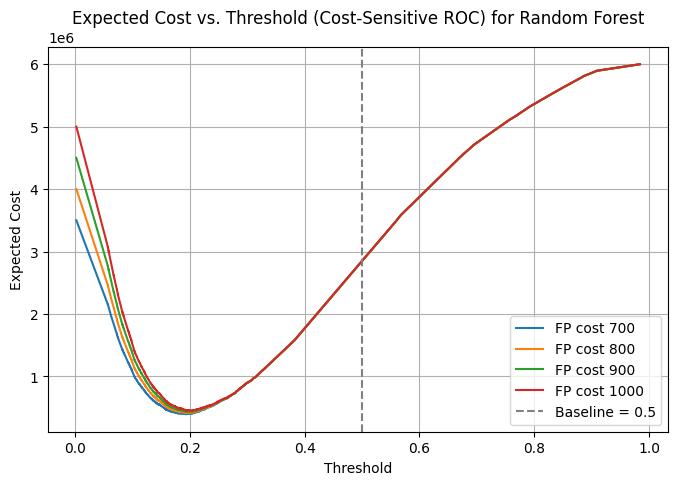

In [32]:
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)  # RF predicted probabilities

# Analyzing Business Costs
C_FN = 1200                        # Cost of missing a fraud
C_FP_values = np.arange(700, 1001, 100)  # Cost range for false positives (700–1000)
baseline_threshold = 0.5           # Current operational cutoff

fpr, tpr, thresholds = roc_curve(y_true, y_score)
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

results = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr,
    'FPR': fpr
})

# Compute cost and baseline savings for each FP cost
best_thresholds = []

baseline_idx = np.argmin(np.abs(thresholds - baseline_threshold))
baseline_tpr = tpr[baseline_idx]
baseline_fpr = fpr[baseline_idx]

for C_FP in C_FP_values:
    # Expected cost at each threshold
    results[f'Cost_FP{C_FP}'] = (
        (C_FP * results['FPR'] * total_neg) + 
        (C_FN * (1 - results['TPR']) * total_pos)
    )
    
    # Baseline cost
    baseline_cost = (
        (C_FP * baseline_fpr * total_neg) + 
        (C_FN * (1 - baseline_tpr) * total_pos)
    )
    
    # Find minimum cost
    idx_min = results[f'Cost_FP{C_FP}'].idxmin()
    min_cost = results.loc[idx_min, f'Cost_FP{C_FP}']
    best_threshold = results.loc[idx_min, 'Threshold']
    
    # Savings = baseline_cost - min_cost
    savings = baseline_cost - min_cost
    
    best_thresholds.append({
        'C_FP': C_FP,
        'Best_Threshold': best_threshold,
        'Baseline_Cost': baseline_cost,
        'Min_Cost': min_cost,
        'Savings': savings,
        'TPR': results.loc[idx_min, 'TPR'],
        'FPR': results.loc[idx_min, 'FPR']
    })

best_df = pd.DataFrame(best_thresholds)

print("Optimal thresholds and cost savings vs baseline (threshold = 0.5):\n")
print(best_df.round(2))

plt.figure(figsize=(8, 5))
for C_FP in C_FP_values:
    plt.plot(results['Threshold'], results[f'Cost_FP{C_FP}'], label=f'FP cost {C_FP}')
plt.axvline(baseline_threshold, color='gray', linestyle='--', label='Baseline = 0.5')
plt.xlabel('Threshold')
plt.ylabel('Expected Cost')
plt.title('Expected Cost vs. Threshold (Cost-Sensitive ROC) for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

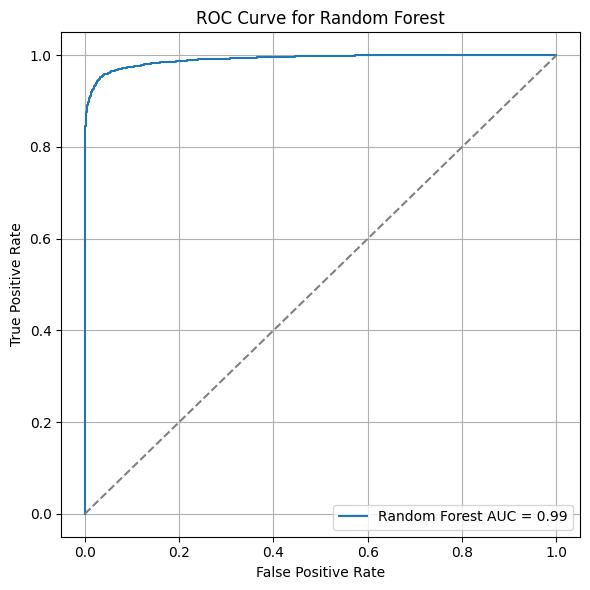

In [33]:
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)  # RF predicted probabilities

fpr, tpr, thresholds = roc_curve(y_true, y_score)

auc = roc_auc_score(y_true, y_score)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Random Forest AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Cost-Optimized Threshold (C_FP = 820)
Optimal Threshold : 0.1927
True Positive Rate: 0.9580
False Positive Rate: 0.0408
Minimum Expected Cost: $419,280.00


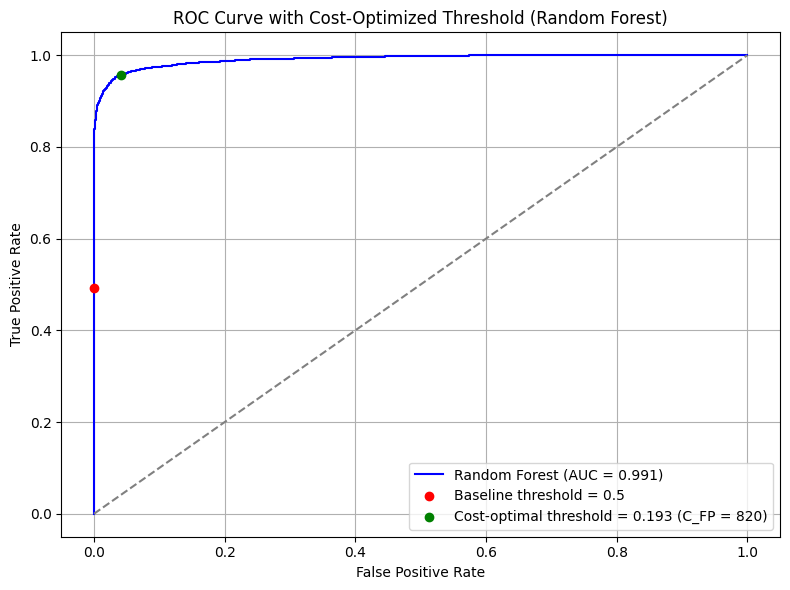

In [45]:
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)  # RF predicted probabilities

fpr_model, tpr_model, thresholds_model = roc_curve(y_true, y_score)
auc_model = roc_auc_score(y_true, y_score)

# Business cost setup
C_FN = 1200   # Cost of false negative (missed fraud)
C_FP = 820    # Cost of false positive (wrongly flagged as fraud)

total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

# Compute total expected business cost for each threshold
costs = (C_FP * fpr_model * total_neg) + (C_FN * (1 - tpr_model) * total_pos)

# Identify optimal threshold minimizing total cost 
idx_min = np.argmin(costs)
optimal_threshold = thresholds_model[idx_min]
optimal_fpr = fpr_model[idx_min]
optimal_tpr = tpr_model[idx_min]
optimal_cost = costs[idx_min]

print("Cost-Optimized Threshold (C_FP = 820)")
print(f"Optimal Threshold : {optimal_threshold:.4f}")
print(f"True Positive Rate: {optimal_tpr:.4f}")
print(f"False Positive Rate: {optimal_fpr:.4f}")
print(f"Minimum Expected Cost: ${optimal_cost:,.2f}")

plt.figure(figsize=(8, 6))

plt.plot(fpr_model, tpr_model, label=f"Random Forest (AUC = {auc_model:.3f})", color='blue')

baseline_idx = np.argmin(np.abs(thresholds_model - 0.5))
plt.scatter(
    fpr_model[baseline_idx],
    tpr_model[baseline_idx],
    color='red',
    label="Baseline threshold = 0.5",
    zorder=5
)

plt.scatter(
    optimal_fpr,
    optimal_tpr,
    color='green',
    label=f"Cost-optimal threshold = {optimal_threshold:.3f} (C_FP = 820)",
    zorder=5
)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Cost-Optimized Threshold (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
precision = []
recall = []
f1score = []

# Evaluate metrics across 0 → 0.99 thresholds
for y in range(100):
    cutoff = y / 100
    train_o['pred'] = (train_o['pred_prob'] > cutoff).astype(int)
    
    precision.append(precision_score(train_o['fraud_bool'], train_o['pred']))
    recall.append(recall_score(train_o['fraud_bool'], train_o['pred']))
    f1score.append(f1_score(train_o['fraud_bool'], train_o['pred']))

f1_s = pd.DataFrame({
    'Cut-off': np.arange(0, 1, 0.01),
    'Precision': precision,
    'Recall': recall,
    'F1': f1score
})

best_f1 = f1_s.sort_values(by='F1', ascending=False)
print("Top thresholds by F1 score:\n")
print(best_f1.head(10))

✅ Top thresholds by F1 score:

    Cut-off  Precision  Recall        F1
20     0.20   0.963816  0.9536  0.958681
21     0.21   0.970076  0.9466  0.958194
19     0.19   0.956132  0.9590  0.957564
22     0.22   0.975250  0.9378  0.956158
18     0.18   0.946026  0.9640  0.954928
23     0.23   0.979532  0.9284  0.953281
24     0.24   0.985011  0.9200  0.951396
17     0.17   0.933680  0.9686  0.950820
25     0.25   0.988256  0.9088  0.946864
16     0.16   0.918761  0.9726  0.944914


/home/appij25/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


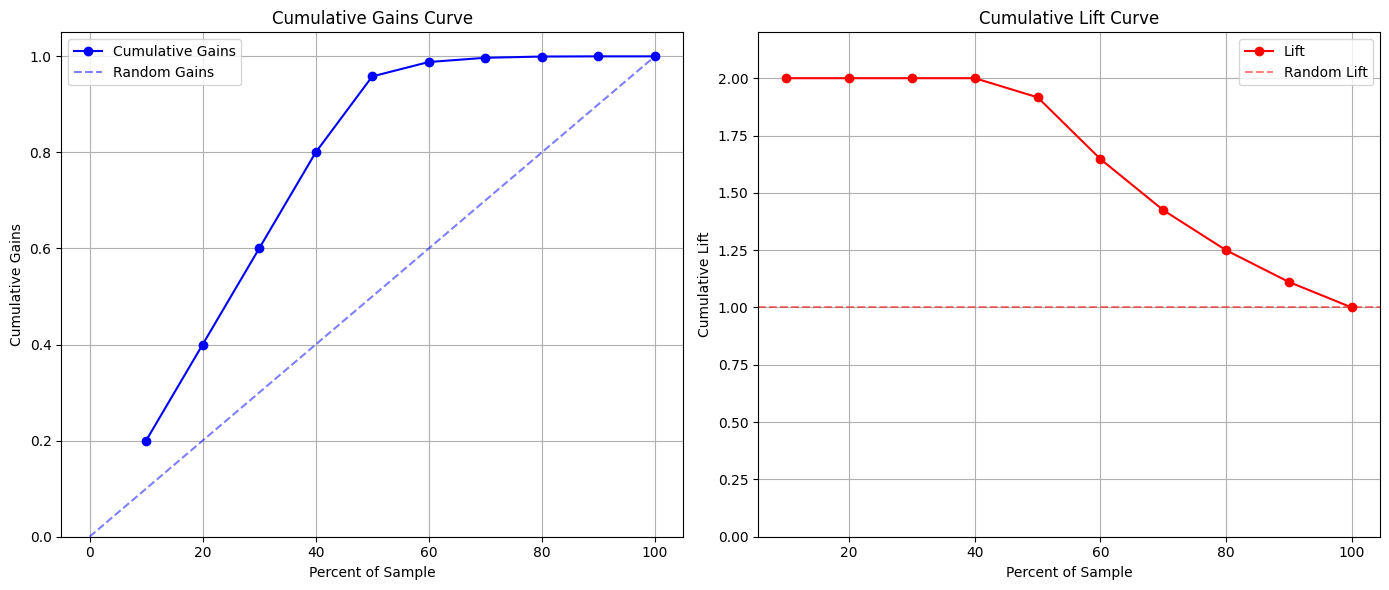

In [37]:
def plot_lift_and_gains(y_true, y_proba, n_bins=10):
    """
    Plot Lift and Cumulative Gains curves.

    Parameters:
    - y_true: array-like, true binary labels (0/1)
    - y_proba: array-like, predicted probabilities for the positive class
    - n_bins: number of bins/deciles to split data
    """
    df = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    
    # Sort descending by predicted probability
    df = df.sort_values(by='y_proba', ascending=False).reset_index(drop=True)
    
    # Cumulative totals
    df['cum_total'] = np.arange(1, len(df) + 1)
    df['cum_positives'] = df['y_true'].cumsum()
    
    total_positives = df['y_true'].sum()
    total_samples = len(df)
    
    # Cumulative Gains: % positives captured vs % samples
    df['cum_gains'] = df['cum_positives'] / total_positives
    
    # Lift: (cumulative gains) / (cumulative % of sample)
    df['cum_lift'] = df['cum_gains'] / (df['cum_total'] / total_samples)
    
    # Sample points for plotting (deciles)
    cutoffs = np.linspace(0, total_samples, n_bins + 1, dtype=int)[1:]  # skip 0
    plot_points = df.loc[cutoffs - 1, ['cum_total', 'cum_gains', 'cum_lift']].copy()
    plot_points['percent_samples'] = plot_points['cum_total'] / total_samples * 100
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Cumulative Gains Curve
    axes[0].plot(plot_points['percent_samples'], plot_points['cum_gains'], marker='o', color='blue', label='Cumulative Gains')
    axes[0].plot([0, 100], [0, 1], linestyle='--', color='blue', alpha=0.5, label='Random Gains')
    axes[0].set_xlabel('Percent of Sample')
    axes[0].set_ylabel('Cumulative Gains')
    axes[0].set_title('Cumulative Gains Curve')
    axes[0].set_ylim(0, 1.05)
    axes[0].grid(True)
    axes[0].legend()
    
    # Lift Curve
    axes[1].plot(plot_points['percent_samples'], plot_points['cum_lift'], marker='o', color='red', label='Lift')
    axes[1].axhline(1, linestyle='--', color='red', alpha=0.5, label='Random Lift')
    axes[1].set_xlabel('Percent of Sample')
    axes[1].set_ylabel('Cumulative Lift')
    axes[1].set_title('Cumulative Lift Curve')
    axes[1].set_ylim(0, plot_points['cum_lift'].max() * 1.1)
    axes[1].grid(True)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_lift_and_gains(train_o['fraud_bool'], train_o['pred_prob'])


# Test

In [39]:
test_o = test.copy()
num_cols_test = test_o.select_dtypes(include='number').columns

for col in num_cols_test:
    if test_o[col].isnull().any():
        # Create missing flag column
        test_o[f'{col}_was_missing'] = test_o[col].isnull().astype(int)

        # Impute with median
        median = test_o[col].median()
        test_o[col] = test_o[col].fillna(median)
print(test_o.columns)

Index(['fraud_bool', 'income', 'salary', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month',
       'email_domain', 'income_was_missing', 'salary_was_missing',
       'prev_address_months_count_was_missing',
       'current_address_months_count_was_missing', 'customer_age_was_missing',
       'days_since_request_was_missing', 'intended_balcon_amount_was_missing',
       'velocity_6h_was_missing', 'velo

In [40]:
predictors_test = test_o.drop(columns=['fraud_bool'])
predictors_test = pd.get_dummies(predictors_test, drop_first=True)
predictors_test = predictors_test.astype(float)

X_test = predictors_test
y_test = test_o['fraud_bool']

In [42]:
from sklearn.metrics import (
    mean_absolute_error, log_loss, brier_score_loss,
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, f1_score
)

X_test1 = X_test[features_to_keep].copy()

# Predict probabilities using weighted logistic model
y_pred_prob = rf_cls.predict(X_test1)

X_test1.head()

,email_is_free,phone_home_valid,has_other_cards,foreign_request,keep_alive_session,prev_address_months_count_was_missing,intended_balcon_amount_was_missing,bank_months_count_was_missing,payment_type_AC,employment_status_CB,...,prev_address_months_count,current_address_months_count,customer_age,velocity_6h,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,34.0,25.0,43.0,13096.035018,5.0,5.0,163.0,9.0,1500.0,5.123877
1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,34.0,89.0,21.0,9223.283431,3.0,18.0,154.0,2.0,1500.0,3.363854
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,9.0,14.0,43.0,4471.472149,15.0,11.0,89.0,30.0,200.0,22.730559
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,11.0,14.0,35.0,14431.993621,11.0,13.0,90.0,1.0,200.0,15.215816
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,34.0,29.0,45.0,7601.511579,1.0,6.0,91.0,26.0,200.0,3.743048


In [50]:
# Convert probabilities to binary predictions using best threshold
best_threshold = 0.1927  # replace with your computed optimal threshold
y_pred_binary = (y_pred_prob >= best_threshold).astype(int)

mae = mean_absolute_error(y_test, y_pred_prob)
ll = log_loss(y_test, y_pred_prob)
brier = brier_score_loss(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_prob)
recall = recall_score(y_test, y_pred_binary)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Log Loss: {ll:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Recall: {recall:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))

Best Threshold: 0.19
Log Loss: 1.8046
Brier Score: 0.0501
Accuracy: 0.9499
AUC: 0.6524
Recall: 0.3511

Confusion Matrix:
 [[949437  46167]
 [  3988   2158]]


In [47]:

X_reduced_r = X_reduced.copy()

X_reduced_r['random'] = np.random.normal(0, 1, X_reduced.shape[0])

In [48]:
y = train_o['fraud_bool']
# --- Random Forest Classifier ---
rf_cls = RandomForestClassifier(
    n_estimators= 800,
    max_features=3,
    max_depth=20,
    random_state=1234,
    oob_score=True,
    class_weight='balanced'  # optional, useful for imbalanced classes
)

# --- Fit the classifier ---
rf_cls.fit(X_reduced_r, y)

# --- Optional: check out-of-bag accuracy ---
print("OOB Accuracy:", rf_cls.oob_score_)


OOB Accuracy: 0.7911


/tmp/ipykernel_144546/2244413676.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette=colors)


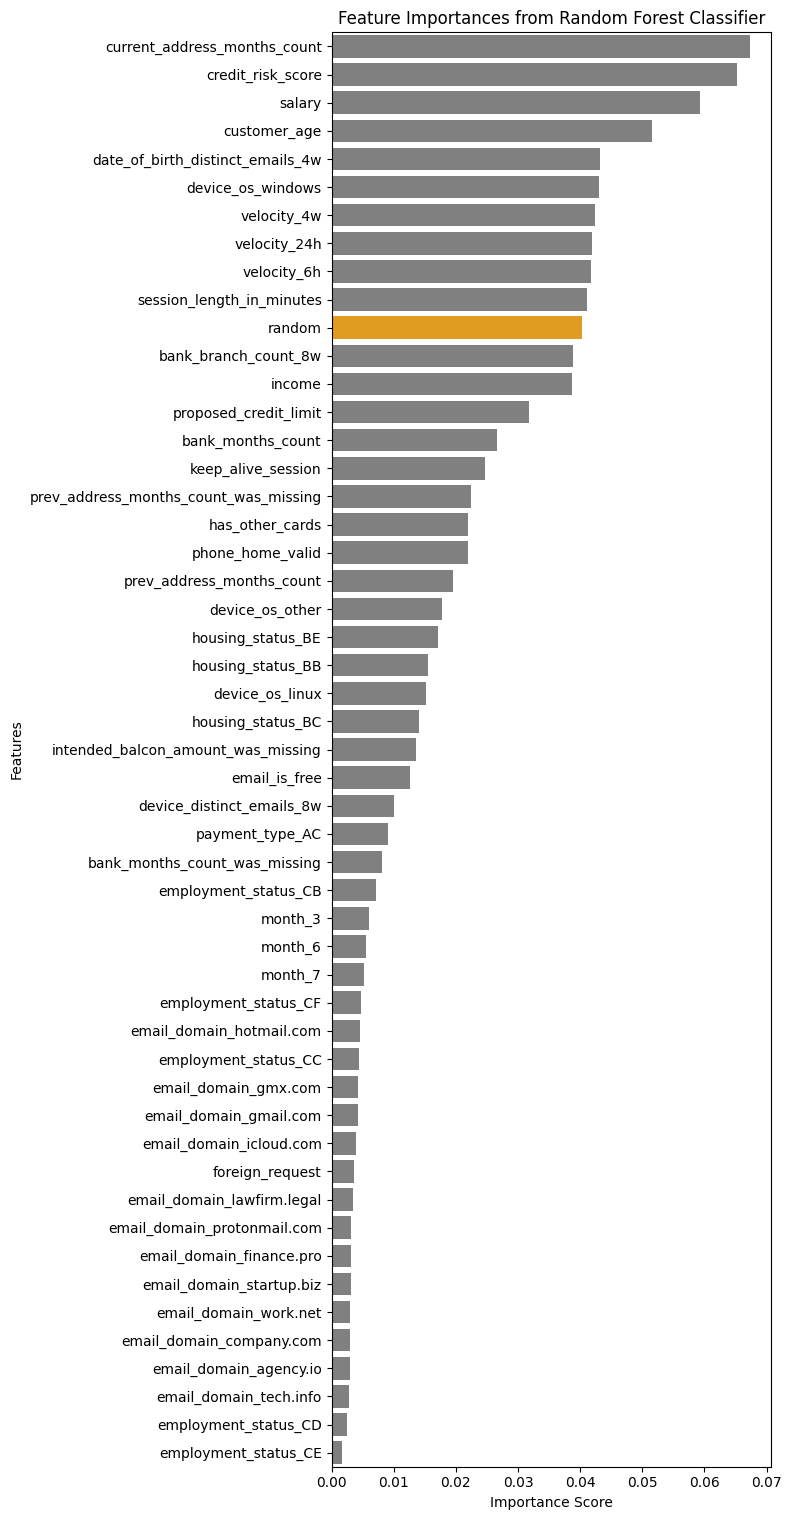

OOB Accuracy: 0.7911


In [51]:
highlight_feature = "random"  # replace with the feature you want to highlight

importances = rf_cls.feature_importances_
feature_importances = pd.Series(importances, index=X_reduced_r.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

colors = ['orange' if feat == highlight_feature else 'gray' for feat in sorted_importances.index]

plt.figure(figsize=(8, len(sorted_importances) * 0.3))  # dynamic height
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette=colors)
plt.title("Feature Importances from Random Forest Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

print("OOB Accuracy:", rf_cls.oob_score_)

Features greater than 'random':
 current_address_months_count        0.067358
credit_risk_score                   0.065217
salary                              0.059236
customer_age                        0.051610
date_of_birth_distinct_emails_4w    0.043179
device_os_windows                   0.043028
velocity_4w                         0.042397
velocity_24h                        0.041986
velocity_6h                         0.041674
session_length_in_minutes           0.041185
dtype: float64


/tmp/ipykernel_144546/4075991952.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette=colors)


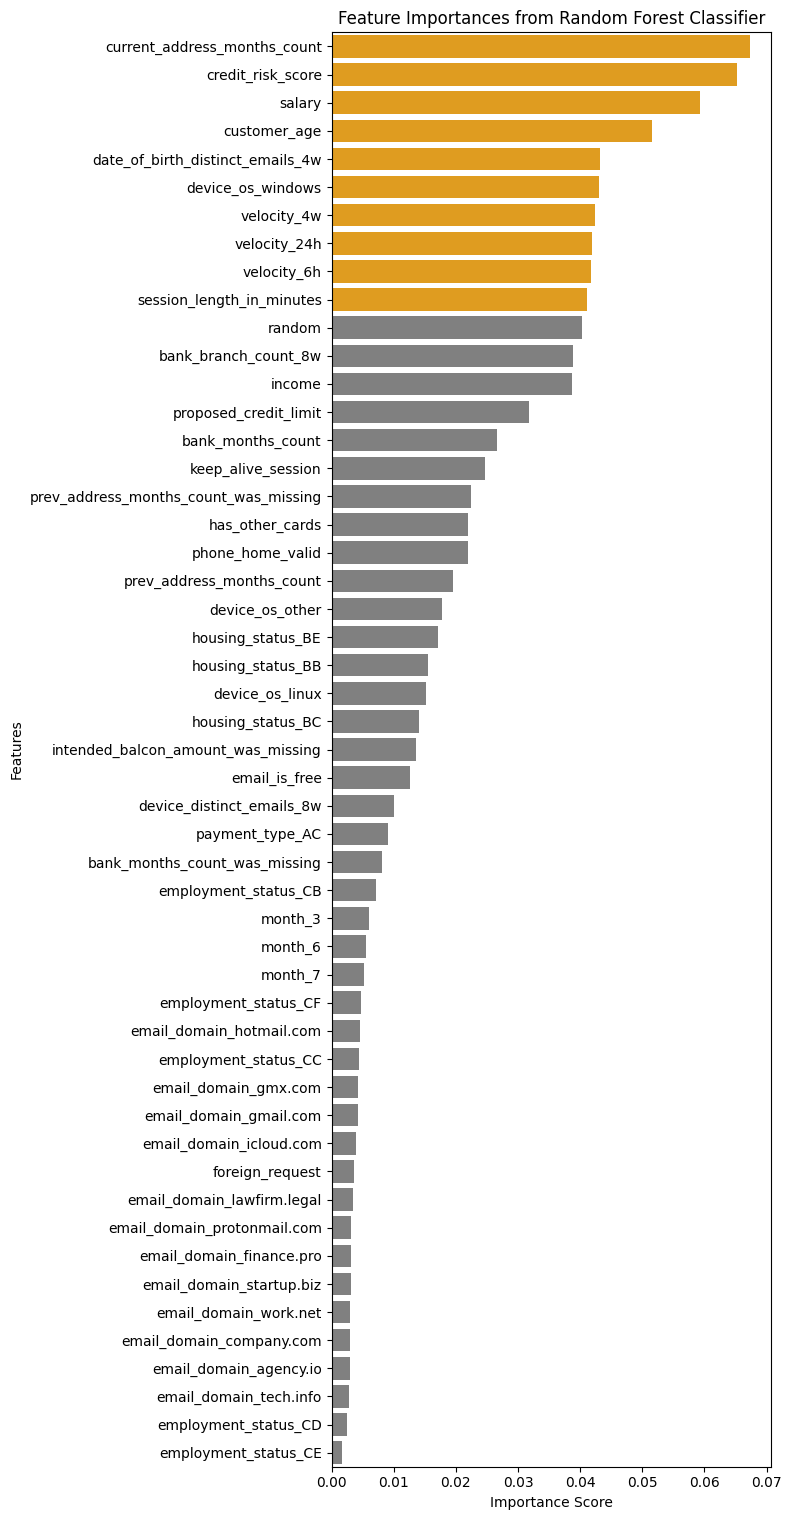

In [52]:
highlight_feature = "random"  # baseline feature

# Compute feature importances
importances = rf_cls.feature_importances_
feature_importances = pd.Series(importances, index=X_reduced_r.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

# Select features greater than "random"
baseline_value = feature_importances.get(highlight_feature, 0)
features_above_random = feature_importances[feature_importances > baseline_value].sort_values(ascending=False)
print("Features greater than 'random':\n", features_above_random)

# Barplot of important features
colors = ['orange' if feat in features_above_random.index else 'gray' for feat in sorted_importances.index]

plt.figure(figsize=(8, len(sorted_importances) * 0.3))  # dynamic height
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette=colors)
plt.title("Feature Importances from Random Forest Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

🔹 Partial Dependence Plot for feature: current_address_months_count


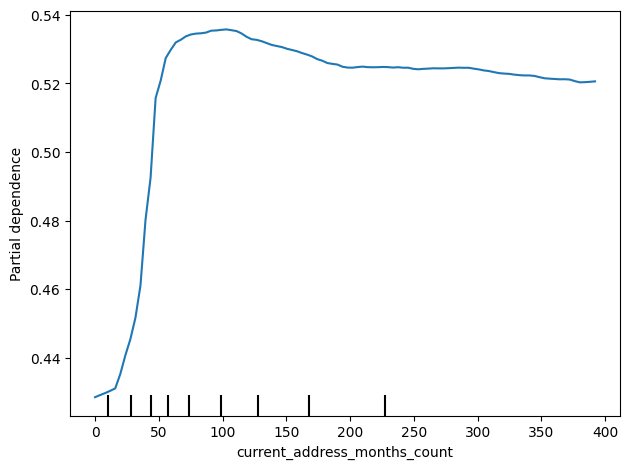

🔹 Partial Dependence Plot for feature: credit_risk_score


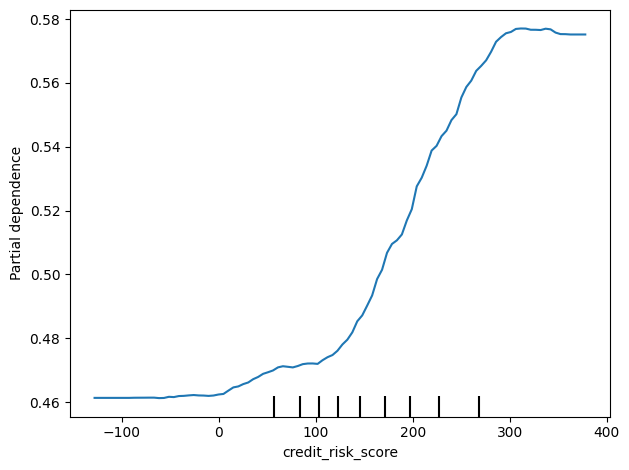

🔹 Partial Dependence Plot for feature: salary


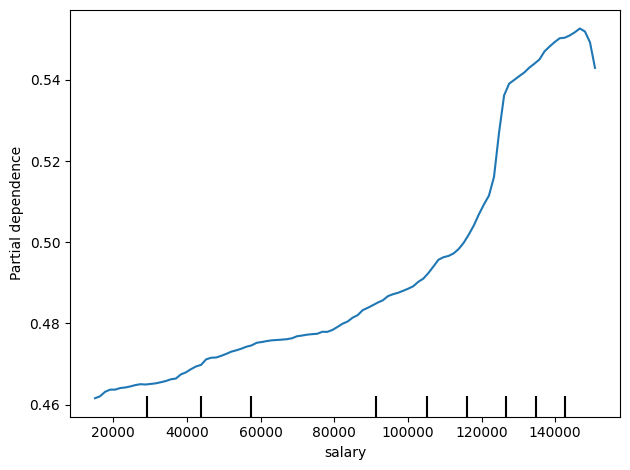

🔹 Partial Dependence Plot for feature: customer_age


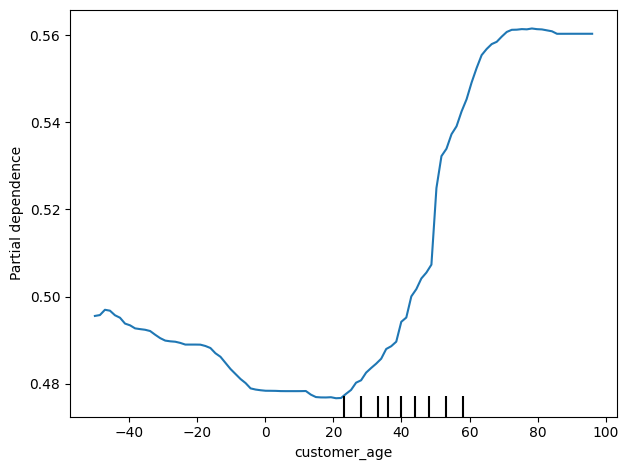

🔹 Partial Dependence Plot for feature: date_of_birth_distinct_emails_4w


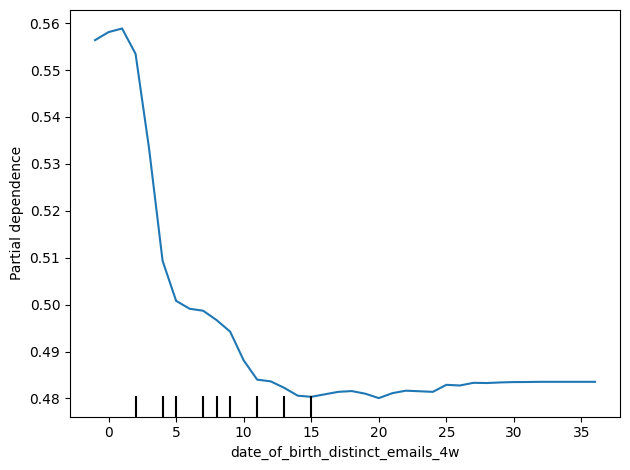

🔹 Partial Dependence Plot for feature: device_os_windows


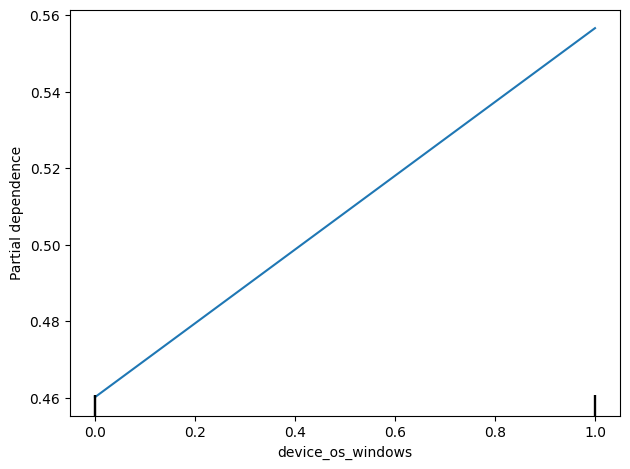

🔹 Partial Dependence Plot for feature: velocity_4w


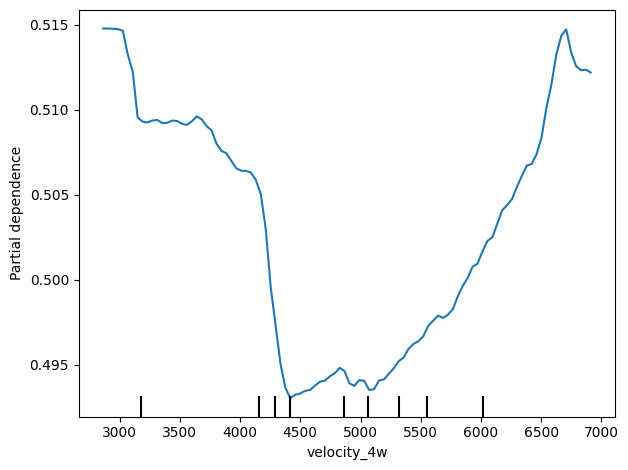

🔹 Partial Dependence Plot for feature: velocity_24h


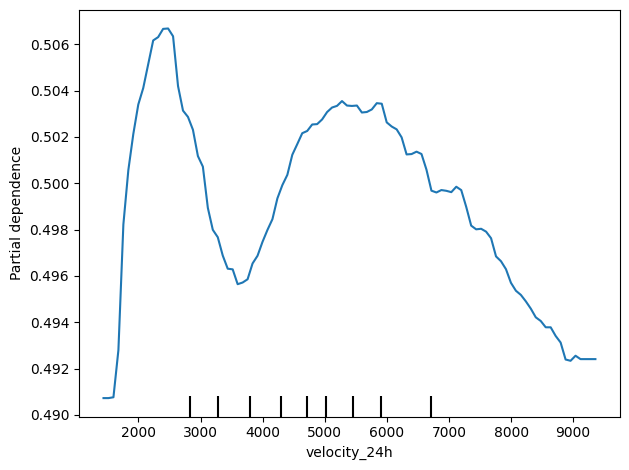

🔹 Partial Dependence Plot for feature: velocity_6h


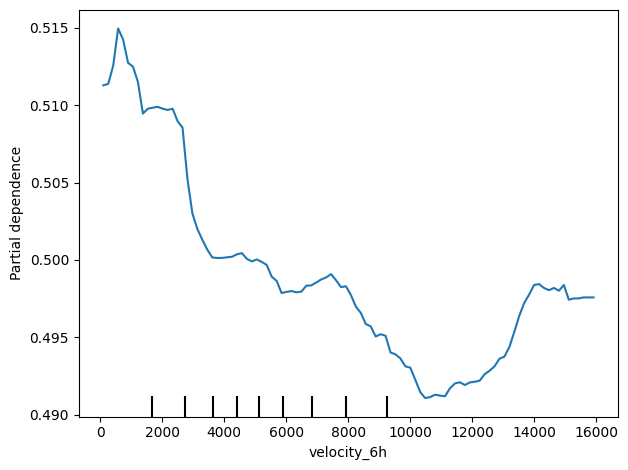

🔹 Partial Dependence Plot for feature: session_length_in_minutes


In [ ]:
# Partial Dependence Plots (PDP) for features above "random"
if len(features_above_random) > 0:
    for feat in features_above_random.index:
        print(f"🔹 Partial Dependence Plot for feature: {feat}")
        PartialDependenceDisplay.from_estimator(
            rf_cls,
            X_reduced_r,
            features=[feat],       # plot one feature at a time
            kind="average",
            percentiles=(0.0, 1.0)
        )
        plt.tight_layout()
        plt.show()
else:
    print("No features have importance greater than 'random'.")
    
if hasattr(rf_cls, "oob_score_"):
    print("OOB Accuracy:", rf_cls.oob_score_)